In [ ]:
!pip install deepxde

In [ ]:
import numpy as np
import pandas as pd
#%matplotlib inline
import matplotlib.pyplot as plt
import random

In [ ]:
import deepxde as dde
import numpy as np

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


#To Define figure size and save Plot

# **Define the model, complie, train and save Loss History**


In [ ]:
import deepxde as dde
from matplotlib import pyplot as plt
import numpy as np
import skopt
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

if dde.backend.backend_name == "pytorch":
    sin = dde.backend.pytorch.sin
else:
    from deepxde.backend import tf

    sin = tf.sin

# General parameters
epochs = 10000
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_xxx = dde.grad.hessian(dy_x, x, i=0, j=0)
    dy_xxxx = dde.grad.hessian(dy_xx, x,i=0, j=0)

    return dy_t + y * dy_x -0.5 * dy_xx

geom = dde.geometry.Interval(0, 10)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, lambda x: np.sin((3.0/5)*np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=500,  num_boundary=100, num_initial=100,num_test=1000)
# The last one is final for our paper


Compiling model...
Building feed-forward neural network...
'build' took 0.078566 s

'compile' took 3.622198 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.29e-02, 4.09e-03, 1.58e-02]    [2.59e-02, 4.09e-03, 1.58e-02]    []  
5         [2.59e-02, 3.23e-03, 1.56e-02]    [2.07e-02, 3.23e-03, 1.56e-02]    []  
10        [2.02e-02, 2.51e-03, 1.55e-02]    [1.63e-02, 2.51e-03, 1.55e-02]    []  
15        [1.55e-02, 1.94e-03, 1.56e-02]    [1.28e-02, 1.94e-03, 1.56e-02]    []  
20        [1.19e-02, 1.49e-03, 1.56e-02]    [9.96e-03, 1.49e-03, 1.56e-02]    []  
25        [9.21e-03, 1.16e-03, 1.57e-02]    [7.79e-03, 1.16e-03, 1.57e-02]    []  
30        [7.17e-03, 9.29e-04, 1.58e-02]    [6.16e-03, 9.29e-04, 1.58e-02]    []  
35        [5.67e-03, 7.69e-04, 1.59e-02]    [4.97e-03, 7.69e-04, 1.59e-02]    []  
40        [4.58e-03, 6.64e-04, 1.59e-02]    [4.13e-03, 6.64e-04, 1.59e-02]    []  
45        [3.80e-03, 5.96e-04, 1.

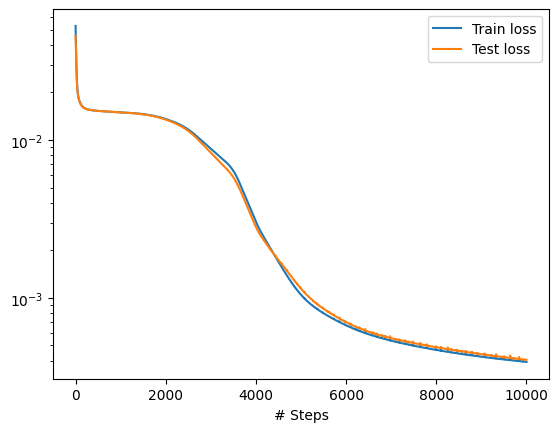

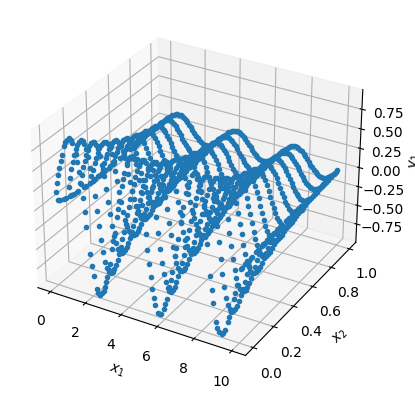

In [ ]:
# [0.00014162001602662018, 4, 16, 'sin', lamda=0.03110204078235363]
lamda=0.03110

net = dde.nn.FNN([2] + [16] * 4 + [1], "sin", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=0.0001416,loss_weights=[1, lamda, lamda])
losshistory, train_state = model.train(iterations=10000,display_every=5)
#model.compile("L-BFGS")
#losshistory, train_state = model.train(iterations=4000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [ ]:
import numpy as np


# Remove boundary_data from training_data
filtered_data = data.test_points()[~np.isin(data.test_points()[:, 0], data.bc_points()[:, 0]) |
                              ~np.isin(data.test_points()[:, 1], data.bc_points()[:, 1])]

# Print the filtered training data
print("Filtered Training Data:")
print(filtered_data)


Filtered Training Data:
[[0.0990099 1.       ]
 [0.1980198 1.       ]
 [0.2970297 1.       ]
 ...
 [9.7029705 0.1      ]
 [9.80198   0.1      ]
 [9.9009905 0.1      ]]


In [ ]:
data.bc_points().shape

(240, 2)

In [ ]:
# Find the common elements
common_elements = np.array([x for x in data.train_points() if np.any(np.all(x == data.test_points(), axis=1))])
num_common_elements = common_elements.shape[0]
# Count the number of different elements
total_elements = data.train_points().shape[0] + data.test_points().shape[0]
num_different_elements = total_elements - num_common_elements

print("Number of common elements:", num_common_elements)
print("Number of different elements:", num_different_elements)

Number of common elements: 240
Number of different elements: 3780


In [ ]:
data.test_points()[:,1].shape

(1240,)

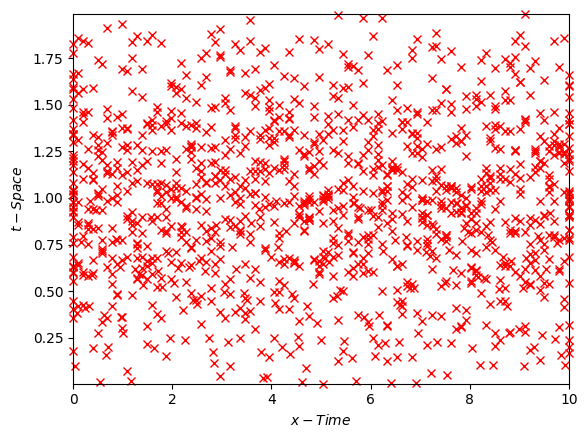

In [ ]:
# Generate random noise between 0 and 1
random_noise = np.random.rand(data.test()[0][:,1].shape[0])
# Add random noise to the second column
data.test()[0][:,1]= data.test()[0][:,1] + random_noise

#data.test()[0][:,1]
plt.plot(data.test()[0][:,0],data.test()[0][:,1],'xr',clip_on = False)
plt.xlabel('$x-Time$')
plt.ylabel('$t-Space$')
plt.autoscale(enable=True, axis='both', tight=True)

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.use('pgf')
import tensorflow as tf
import numpy as np
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspe

In [ ]:
t=np.linspace(0,1,101).reshape(-1,1)
x=np.linspace(0,10,101).reshape(-1,1)
usol=np.zeros(shape=(101,101))


for i in range(101): # i for t and j for x
  for j in range(101):
      usol[i][j]=1+((120*0.0025)/((1+x[j]+t[i])**3))

exact=usol.T
xx, tt = np.meshgrid(x, t)
X = np.vstack((np.ravel(xx), np.ravel(tt))).T
y = exact.flatten()[:, None]

y_true = y
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

U_pred = griddata(X, y_pred.flatten(), (xx, tt), method='cubic')

Mean residual: 0.00502651
L2 relative error: 1.0574340122711048


In [ ]:
U_pred.shape

(101, 101)

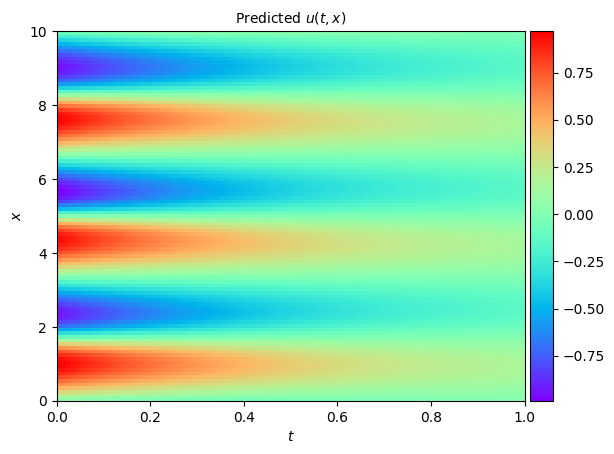

In [ ]:
import matplotlib.gridspec as gridspe
from matplotlib.gridspec import GridSpec
%matplotlib inline
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
line = np.linspace(x.min(), x.max(), 2)[:,None]

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('Predicted $u(t,x)$', fontsize = 10)
plt.savefig('u_pred1.eps',dpi=100)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
Nx = 100  # N0umber of grid points in x
Nt = 100  # Number of grid points in t
T = 1.0   # Total time

# Discretization steps
dx = 10.0 / Nx
dt = T / Nt

# Create grid
x = np.linspace(0, 10, Nx+1)
t = np.linspace(0, T, Nt+1)

u = np.zeros((Nt+1, Nx+1))
# Set the boundary condition
u[:,0]=0
u[:,Nx]=0

####Set the initial condition
#u[0, :] = np.exp(-4*(x-5)**2)
u[0, :] = np.sin(3*np.pi*x/5)

#u[0, :] = np.cos(4*np.pi*x/5)

# Solve the PDE using finite differences
for n in range(Nt):
    for i in range(1, Nx):
        u_x = (u[n, i+1] - u[n, i-1]) / (2 * dx)  # Centered difference for u_x
        u_xx = (u[n, i+1] - 2*u[n, i] + u[n, i-1]) / dx**2  # Centered difference for u_xx
        ##u_xxxx = (u[n, i+3] - 4*u[n, i+2] + 6*u[n, i+1]- 4*u[n, i]+ u[n, i-1]) / dx**4  # Centered difference for u_xxxx
        u_t = -u[n, i] * u_x  # Given equation u_t + u * u_x = 0.5 * u_xx

        u[n+1, i] = u[n, i] + dt * (0.5 * u_xx - u_t)

# Create meshgrid for plotting
X, T = np.meshgrid(x, t)

# Plot the solution as a contour plot
plt.figure(figsize=(10, 6))
plt.contourf(T, X, u, interpolation='nearest', cmap='rainbow')

plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Solution of the PDE: u_t + u * u_x = 0.5 * u_xx')
plt.show()

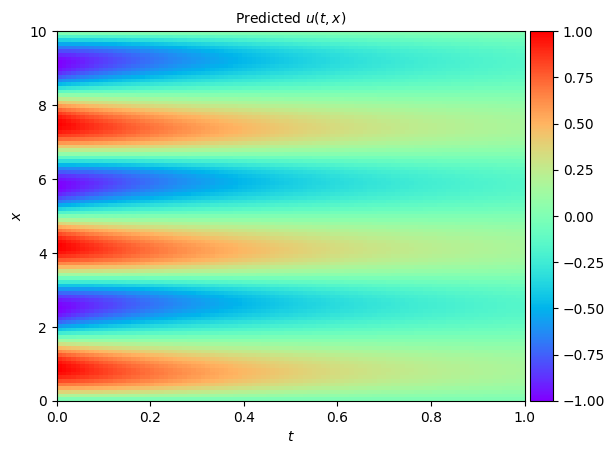

In [ ]:
import matplotlib.gridspec as gridspe
from matplotlib.gridspec import GridSpec
%matplotlib inline
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()

h = ax.imshow(u.T, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('Predicted $u(t,x)$', fontsize = 10)
plt.savefig('u_pred1.eps',dpi=100)

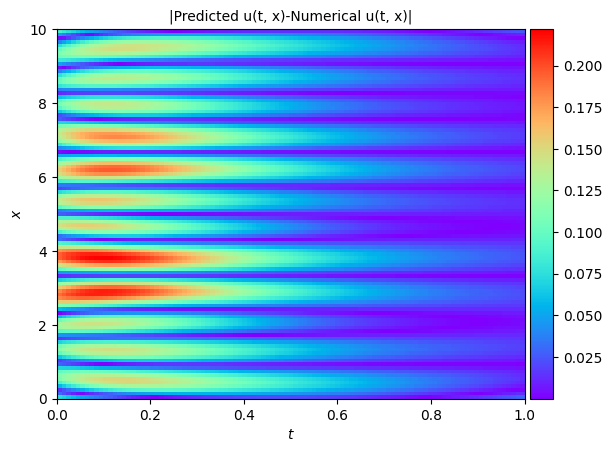

In [ ]:
import matplotlib.gridspec as gridspe
from matplotlib.gridspec import GridSpec
%matplotlib inline
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()


h = ax.imshow(abs(U_pred.T-u.T), interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('|Predicted u(t, x)-Numerical u(t, x)|', fontsize = 10)
plt.savefig('u_difference_exp_mod.eps',dpi=100)

In [ ]:
import numpy as np

# Define parameters
L = 10.0  # Length of the spatial domain
T = 1.0   # Total simulation time
Nx = 101  # Number of spatial points (including boundary points)
Nt = 101  # Number of time steps (including initial time)
dx = L / (Nx - 1)
dt = T / (Nt - 1)

# Create grids for x and t
x = np.linspace(0, L, Nx)
t = np.linspace(0, T, Nt)

# Initialize arrays for the approximate solution and residual
u = np.zeros((Nx, Nt))
residual = np.zeros((Nx, Nt))

# Define the initial condition
u[:, 0] = np.sin(3 * np.pi * x / 5)

# Time-stepping loop to compute the approximate solution
for n in range(0, Nt - 1):
    for i in range(1, Nx - 1):
        u[i, n + 1] = u[i, n] - (u[i, n] * (u[i, n] - u[i - 1, n]) / dx) * dt + 0.5 * (u[i + 1, n] - 2 * u[i, n] + u[i - 1, n]) * (dt / dx**2)

# Compute the residual at each point in space and time
for n in range(0, Nt - 1):
    for i in range(1, Nx - 1):
        residual[i, n] = (u[i, n + 1] - u[i, n]) / dt + u[i, n] * (u[i, n] - u[i - 1, n]) / dx - 0.5 * (u[i + 1, n] - 2 * u[i, n] + u[i - 1, n]) / dx**2

# Compute the L2 norm of the residual
residual_norm = np.linalg.norm(residual)

print(f"L2 Norm of Residual: {residual_norm}")

L2 Norm of Residual: 2.5024620774853734e-13


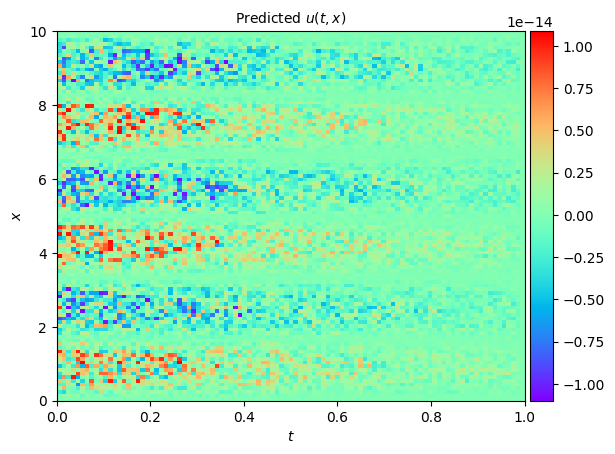

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
L = 10.0  # Length of the spatial domain
T = 1.0   # Total simulation time
Nx = 101  # Number of spatial points (including boundary points)
Nt = 101  # Number of time steps (including initial time)
dx = L / (Nx - 1)
dt = T / (Nt - 1)

# Create grids for x and t
x = np.linspace(0, L, Nx)
t = np.linspace(0, T, Nt)

# Initialize arrays for the approximate solution and residual
u = np.zeros((Nx, Nt))
residual = np.zeros((Nx, Nt))

# Define the initial condition
u[:, 0] = np.sin(3 * np.pi * x / 5)

# Time-stepping loop to compute the approximate solution
for n in range(0, Nt - 1):
    for i in range(1, Nx - 1):
        u[i, n + 1] = u[i, n] - (u[i, n] * (u[i, n] - u[i - 1, n]) / dx) * dt + 0.5 * (u[i + 1, n] - 2 * u[i, n] + u[i - 1, n]) * (dt / dx**2)

# Compute the residual at each point in space and time
for n in range(0, Nt - 1):
    for i in range(1, Nx - 1):
        residual[i, n] = (u[i, n + 1] - u[i, n]) / dt + u[i, n] * (u[i, n] - u[i - 1, n]) / dx - 0.5 * (u[i + 1, n] - 2 * u[i, n] + u[i - 1, n]) / dx**2

# Create a meshgrid for x and t
X, T = np.meshgrid(x, t)
import matplotlib.gridspec as gridspe
from matplotlib.gridspec import GridSpec
%matplotlib inline
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()

h = ax.imshow(residual, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
line = np.linspace(x.min(), x.max(), 2)[:,None]

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('Predicted $u(t,x)$', fontsize = 10)
plt.savefig('u_pred1.eps',dpi=100)